<a href="https://colab.research.google.com/github/moukouel/Notebooks/blob/main/StackedCNNDenoise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Denoising Images using a convolutional NN

In [6]:

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D


In [7]:
np.random.seed(11)
tf.random.set_seed(11)
batch_size = 128
max_epochs = 60
learning_rate = 1e-3
filters = [32, 32, 16]

In [8]:
# Load the MNIST dataset and introduce noise

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
#Reshape the data to be (60000, 28, 28, 1) and (10000, 28, 28, 1)
x_train = np.expand_dims(x_train, axis=-1)

x_test = np.expand_dims(x_test, axis=-1)

# Add Gaussian noise to the training data and convert to float32

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
# Clip the values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)

x_train_noisy = x_train_noisy.astype('float32')
# Add Gaussian noise to the test data
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
# Clip the values to be between 0 and 1
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_test_noisy = x_test_noisy.astype('float32')
# Create tensor slices for the training and test data
train_dataset = tf.data.Dataset.from_tensor_slices(x_train_noisy).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(x_test_noisy).batch(batch_size)


In [9]:
# Create an Encoder Layer class with  three convolutional layers
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        super(EncoderLayer, self).__init__()
        self.conv1 = Conv2D(filters[0], kernel_size, strides=strides, padding=padding, activation=activation)
        self.conv2 = Conv2D(filters[1], kernel_size, strides=strides, padding=padding, activation=activation)
        self.conv3 = Conv2D(filters[2], kernel_size, strides=strides, padding=padding, activation=activation)
        self.pool = MaxPooling2D(pool_size=(2, 2), padding='same')


    def call(self, input_features):
        x = self.conv1(input_features)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        return x

# Create a Decoder Layer class with four convolutional layers and one upsampling layer
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size=3, strides=1, padding='same', activation='relu'):
        super(DecoderLayer, self).__init__()
        self.conv1 = Conv2D(filters[2], kernel_size, strides=strides, padding=padding, activation=activation)
        self.conv2 = Conv2D(filters[1], kernel_size, strides=strides, padding=padding, activation=activation)
        self.conv3 = Conv2D(filters[0], kernel_size, strides=strides, padding=padding, activation=activation)
        self.upsample = UpSampling2D(size=(2, 2))
        self.conv4 = Conv2D(1, 3, 1, activation='sigmoid', padding='same')

    def call(self, input_features):
        x = self.conv1(input_features)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.upsample(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        return x
# Create a custom Autoencoder class that combines the Encoder and Decoder layers
class Autoencoder(tf.keras.Model):
    def __init__(self, filters):
        super(Autoencoder, self).__init__()
        self.encoder = EncoderLayer(filters)
        self.decoder = DecoderLayer(filters)

    def call(self, input_features):
        x = self.encoder(input_features)
        x = self.decoder(x)
        return x

In [10]:
# Create a custom Autoencoder class that resizes the output
class Autoencoder(tf.keras.Model):
	def __init__(self, filters):
		super(Autoencoder, self).__init__()
		self.encoder = EncoderLayer(filters)
		self.decoder = DecoderLayer(filters)
		self.resize = tf.keras.layers.Resizing(28, 28)

	def call(self, input_features):
		x = self.encoder(input_features)
		x = self.decoder(x)
		return self.resize(x)

# Create the convolutional autoencoder model
autoencoder = Autoencoder(filters)
# Compile the model with Adam optimizer and binary crossentropy loss
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='binary_crossentropy')

# Create dataset tuples for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train)).shuffle(60000).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test_noisy, x_test)).batch(batch_size)
# Train the model using the datasets
history = autoencoder.fit(train_dataset, epochs=max_epochs, validation_data=test_dataset, verbose=1)

Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.2734 - val_loss: 0.1495
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1458 - val_loss: 0.1320
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1317 - val_loss: 0.1251
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1253 - val_loss: 0.1208
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1206 - val_loss: 0.1165
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1176 - val_loss: 0.1150
Epoch 7/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1157 - val_loss: 0.1129
Epoch 8/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1138 - val_loss: 0.1112
Epoch 9/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1119 - val_loss: 0.1098
Epoch 10/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1107 - val_loss: 0.1094
Epoch 11/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1096 - val_loss: 0.1080
Epoch 12/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

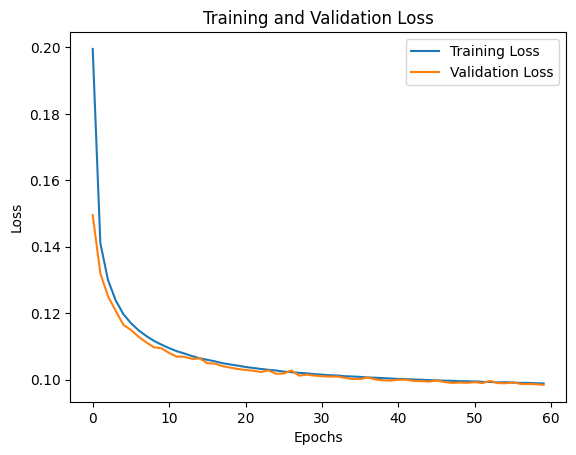

In [11]:
# Plot the training and validation loss
plt.plot(range(max_epochs), history.history['loss'], label='Training Loss')
plt.plot(range(max_epochs), history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

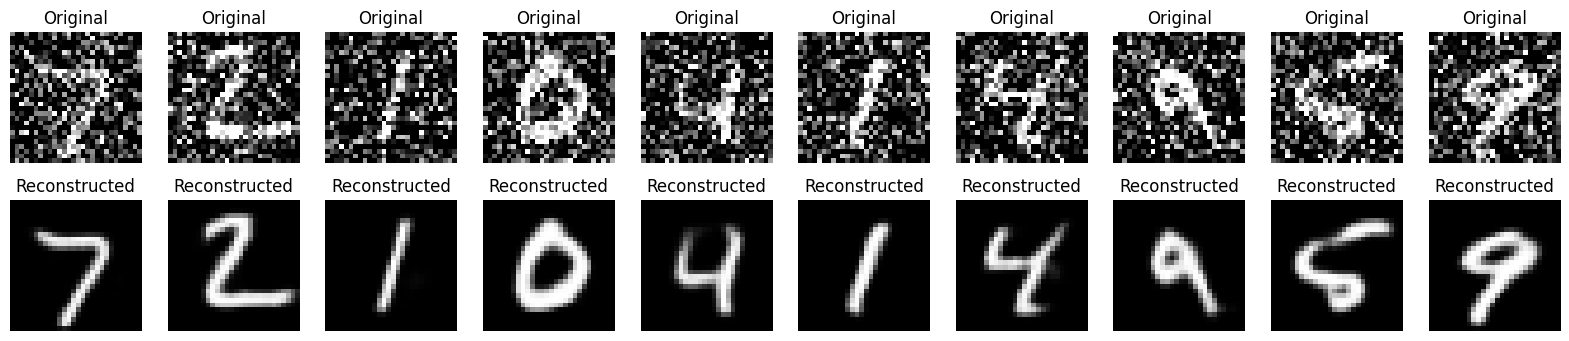

In [12]:
# Display the original and reconstructed images
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.reshape(autoencoder(x_test_noisy)[i], (28, 28)), cmap='gray')
    plt.title("Reconstructed")
    plt.axis("off")
plt.show()